<a href="https://colab.research.google.com/github/shinchacoffee/CIFAR10_practice/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
random_seed=1
train_batch_size=100
test_batch_size=1000
n_epochs=1
torch.manual_seed(random_seed)

In [3]:
train_norm_load = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train = True,
                                 transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                            ]),
                                            download = True),
                            batch_size=train_batch_size, shuffle = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /files/cifar-10-python.tar.gz to /files/


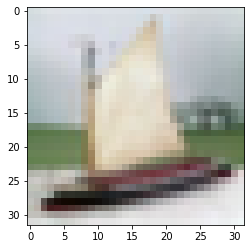

In [4]:
import matplotlib.pyplot as plt
fig2=plt.figure()
for x,y in train_norm_load:
  xx=torch.movedim(x[0], (0,1,2), (2,0,1))
  plt.imshow(xx)
  break

In [5]:
RGB_sum = torch.zeros(3)
RGB_sum_sq = torch.zeros(3)
for x,y in train_norm_load:
  RGB_sum += torch.mean(x, dim=(0,2,3))#*x.shape[0]
  RGB_sum_sq += torch.mean(x*x, dim=(0,2,3))#*x.shape[0]
RGB_mean = RGB_sum / len(train_norm_load)
RGB_std  = (RGB_sum_sq / len(train_norm_load) - RGB_mean ** 2)**0.5
print(RGB_mean,RGB_std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [6]:


train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train = True,
                                 transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                RGB_mean, RGB_std )
                                            ]),
                                            download = True),
                            batch_size=train_batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train = False,
                                 transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                (0.5, 0.5, 0.5), (0.2, 0.2, 0.2) )
                                            ]), #why not working when without enter?
                                            download = True),
                            batch_size=test_batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
RGB_sum = torch.zeros(3)
RGB_sum_sq = torch.zeros(3)
for x,y in train_loader:
  RGB_sum += torch.mean(x, dim=(0,2,3))#*x.shape[0]
  RGB_sum_sq += torch.mean(x*x, dim=(0,2,3))#*x.shape[0]
RGB_mean = RGB_sum / len(train_loader)
RGB_std  = (RGB_sum_sq / len(train_loader) - RGB_mean ** 2)**0.5
print(RGB_mean,RGB_std)

tensor([-7.9392e-07,  3.6231e-07, -5.1742e-07]) tensor([1.0000, 1.0000, 1.0000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


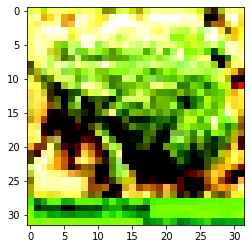

In [8]:
import matplotlib.pyplot as plt
fig1=plt.figure()
for x,y in train_loader:
  xx=torch.movedim(x[0], (0,1,2), (2,0,1))
  plt.imshow(xx)
  break

In [9]:
import torch.nn
import torch.nn.functional
import torch.optim

In [10]:
class My_net(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3,9,5)
    self.conv2 = torch.nn.Conv2d(9,15,5)
    self.conv2drop = torch.nn.Dropout2d(p=0.5)
    self.line1 = torch.nn.Linear(375,50)
    self.line2 = torch.nn.Linear(50,10)

  def forward(self, signal):
    #print(signal.shape)
    signal = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(signal),2))
    #print(signal.shape)
    signal = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2drop(self.conv2(signal)),2))
    #print(signal.shape)
    signal = signal.view(signal.shape[0],-1)
    #print(signal.shape)
    signal = torch.nn.functional.relu(self.line1(signal))
    signal = torch.nn.functional.dropout(signal,p=0.5)
    #print(signal.shape)
    signal = torch.nn.functional.relu(self.line2(signal))
    #print(signal.shape)
    return torch.nn.functional.log_softmax(signal)

In [80]:
network = My_net()
#network_nonnorm = My_net()
learnin_rate = 0.003
my_momentum = 0.73
optimizer = torch.optim.SGD(network.parameters(), lr=learnin_rate, momentum=my_momentum)
#optimizer_non = torch.optim.SGD(network_nonnorm.parameters(), lr=learnin_rate, momentum=my_momentum)

In [ ]:
network(torch.rand(3,3,32,32))

torch.Size([3, 500])


RuntimeError: ignored

In [79]:
train_losses = []
train_counter = []
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()

    #rotator = torchvision.transforms.RandomRotation(degrees=(-10, 10))
    #data = rotator(data)
    #prob=torch.rand(1)
    #if prob[0] > 0.5:
    #  data = torchvision.transforms.Grayscale(num_output_channels=3)(data)
    my_transforms = torch.nn.ModuleList([#torchvision.transforms.ColorJitter(), #useless cause by default is zero
                                         torchvision.transforms.RandomGrayscale(p=0.2),
                                         torchvision.transforms.RandomRotation(degrees=(-10, 10)),
                                         torchvision.transforms.RandomPerspective(),
                                         torchvision.transforms.RandomVerticalFlip(p=0.5)#,
                                         #torchvision.transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
                                         ])
    randtran = torchvision.transforms.RandomApply(transforms=my_transforms, p=0.7)
    data = randtran(data)

    output = network(data)
    loss = torch.nn.functional.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [ ]:
n_epochs=10
for epoch in range(1, n_epochs+1):
  train(epoch)

In [82]:
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += torch.nn.functional.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [84]:
test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.7806, Accuracy: 3522/10000 (35%)

